In [ ]:
# ! pip install -q whylogs
# ! pip install -q 'whylogs[viz]'

In [5]:
import pandas as pd
import numpy as np 

In [54]:
train_df = pd.read_csv('../data/ml_100k/train_data.csv')

train_df.head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [55]:
def buildInferenceSheet(train_df, item_col, user_col):
    all_items = train_df[item_col].unique()
    num_items = train_df[item_col].nunique()
    all_users = train_df[user_col].unique()
    cmp_test_df = []
    for u in all_users:
        user_sub = train_df.loc[train_df[user_col]==u, :][item_col].unique()
        cmp_test_df.append(pd.DataFrame({'user_id': [u,]*num_items, 'item_id': all_items,  'subscription_status': np.in1d(all_items, user_sub)}))
    cmp_test_df = pd.concat(cmp_test_df, axis=0)
    return cmp_test_df

In [21]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'],unit='s')
train_df

,user_id,item_id,rating,timestamp
0,1,1,5,1997-09-22 22:02:38
1,1,2,3,1997-10-15 05:26:11
2,1,3,4,1997-11-03 07:42:40
3,1,4,3,1997-10-15 05:25:19
4,1,5,3,1998-03-13 01:15:12
...,...,...,...,...
79995,943,1067,2,1997-09-29 02:55:56
79996,943,1074,4,1998-02-28 04:30:50
79997,943,1188,3,1998-02-28 04:30:50
79998,943,1228,3,1998-02-28 04:31:15


In [16]:
srt_df = train_df.sort_values(by='timestamp')
srt_df.head()

,user_id,item_id,rating,timestamp
13804,259,286,4,1997-09-20 03:05:27
13808,259,298,4,1997-09-20 03:05:54
13802,259,185,4,1997-09-20 03:06:21
13799,259,173,4,1997-09-20 03:07:23
13805,259,288,3,1997-09-20 03:08:25


In [22]:
print(f"first date : {train_df['timestamp'].min()} | last date : {train_df['timestamp'].max()}")

first date : 1997-09-20 03:05:27 | last date : 1998-04-22 23:10:38


In [23]:
import cornac
from recommenders.datasets.python_splitters import python_chrono_split
train_df, val_df = python_chrono_split(train_df,
                                        ratio=0.8,
                                        min_rating=10,
                                        filter_by='user',
                                        col_user='user_id',
                                        col_item='item_id',
                                        col_timestamp='timestamp')

FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


In [25]:
print(f"train_df size : {train_df.shape} | validation_df size : {val_df.shape}")

train_df size : (63958, 4) | validation_df size : (15996, 4)


In [26]:
import whylogs as why
result = why.log(pandas=val_df)
prof_view = result.view()

In [27]:
result_ref = why.log(pandas=train_df)
prof_view_ref = result_ref.view()


In [28]:
from whylogs.viz import NotebookProfileVisualizer

visualization = NotebookProfileVisualizer()
visualization.set_profiles(target_profile_view=prof_view, reference_profile_view=prof_view_ref)

In [29]:
visualization.summary_drift_report()


*_Does not work well_

---
build custom data drift analysis algorithms

In [39]:
test_df = pd.read_csv('../data/ml_100k/test_data.csv')
test_df.head()

,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [32]:
def getPopularItems(df):
    df = df.copy()
    item_pop = df['item_id'].value_counts(ascending=False).to_dict()
    # srt_pop = {k: v for k, v in sorted(item_pop.items(), key=lambda item: item[0])}
    return item_pop

In [48]:
train_popular_items = getPopularItems(train_df)
# list(zip(train_popular_items.keys(), train_popular_items.values()))[:10]
train_pop_15 = list(train_popular_items.keys())[:15]
train_pop_15

[50, 181, 258, 100, 294, 288, 286, 1, 300, 174, 121, 127, 7, 237, 56]

In [49]:
val_popular_items = getPopularItems(val_df)
# list(zip(val_popular_items.keys(), val_popular_items.values()))[:10]
val_pop_15 = list(val_popular_items.keys())[:15]
val_pop_15

[94, 88, 313, 739, 151, 50, 121, 546, 231, 449, 1, 117, 393, 70, 405]

In [50]:
test_popular_items = getPopularItems(test_df)
# list(zip(test_popular_items.keys(), test_popular_items.values()))[:10]
test_pop_15 = list(test_popular_items.keys())[:15]
test_pop_15

[100, 258, 50, 286, 294, 98, 288, 7, 181, 56, 300, 174, 117, 121, 237]

In [51]:
train_pop_15s, test_pop_15s = set(train_pop_15), set(test_pop_15)
common_pop = train_pop_15s & test_pop_15s
common_prec = len(common_pop) / len(train_pop_15s | test_pop_15s)
print(f"""
Train-Test time Item Popularity change > 
    common popular items : {common_pop},
    common pop percentage : {common_prec},
    vanished pop items in test : {train_pop_15s - test_pop_15s},
    new popular items in test : {test_pop_15s - train_pop_15s}
""")


Train-Test time Item Popularity change > 
    common popular items : {288, 258, 100, 294, 7, 300, 237, 174, 50, 181, 56, 121, 286},
    common pop percentage : 0.7647058823529411,
    vanished pop items in test : {1, 127},
    new popular items in test : {98, 117}



In [52]:
# sample Rec. model training 
from recommenders.utils.timer import Timer
SEED = 43

train_dt = cornac.data.Dataset.from_uir(train_df.loc[:, ['user_id', 'item_id', 'rating']].itertuples(index=False), seed=SEED)
val_dt = cornac.data.Dataset.from_uir(val_df.loc[:, ['user_id', 'item_id', 'rating']].itertuples(index=False), seed=SEED)

model = cornac.models.SVD(
    k=32,
    max_iter=100,
    learning_rate=0.001,
    lambda_reg=0.0001,
    early_stop=True,
    num_threads=0,
    verbose=True,
    seed=123
)

with Timer() as t:
    model.fit(train_dt, val_set=val_dt)
print("Took {} seconds for training.".format(t))

100%|██████████| 100/100 [00:00<00:00, 300.10it/s, loss=26107.08]


Optimization finished!
Took 0.3383 seconds for training.


In [53]:
from recommenders.models.cornac.cornac_utils import predict_ranking, predict
def predictTopK(model, dataset, user_col, item_col, k=10):
    preds = predict(model, dataset, usercol=user_col, itemcol=item_col)
    srt_preds = preds.sort_values(by='prediction', ascending=False)
    topK_preds = srt_preds.groupby(user_col).head(k)
    return topK_preds

In [57]:
infer_df = buildInferenceSheet(train_df, 'item_id', 'user_id')
infer_df

,user_id,item_id,subscription_status
0,1,1,True
1,1,2,True
2,1,3,True
3,1,4,True
4,1,5,True
...,...,...,...
1645,943,1679,False
1646,943,1680,False
1647,943,907,False
1648,943,1681,False


In [59]:
pred_df = predictTopK(model, infer_df.loc[infer_df['subscription_status']==False, :], user_col='user_id', item_col='item_id', k=15)


In [60]:
pred_popular_items = getPopularItems(pred_df)
# list(zip(test_popular_items.keys(), test_popular_items.values()))[:10]
pred_pop_15 = list(pred_popular_items.keys())[:15]
pred_pop_15

[513, 408, 169, 480, 479, 515, 603, 483, 357, 12, 64, 318, 98, 285, 174]

In [61]:
train_pop_15s, test_pop_15s = set(test_pop_15), set(pred_pop_15)
common_pop = train_pop_15s & test_pop_15s
common_prec = len(common_pop) / len(train_pop_15s | test_pop_15s)
print(f"""
Test-Predicted time Item Popularity change > 
    common popular items : {common_pop},
    common pop percentage : {common_prec},
    vanished pop items in test : {train_pop_15s - test_pop_15s},
    new popular items in test : {test_pop_15s - train_pop_15s}
""")


Test-Predicted time Item Popularity change > 
    common popular items : {98, 174},
    common pop percentage : 0.07142857142857142,
    vanished pop items in test : {288, 258, 100, 294, 7, 300, 237, 50, 181, 117, 56, 121, 286},
    new popular items in test : {480, 513, 64, 515, 483, 357, 169, 12, 408, 603, 285, 318, 479}



In [62]:
train_pop_15s, test_pop_15s = set(train_pop_15), set(pred_pop_15)
common_pop = train_pop_15s & test_pop_15s
common_prec = len(common_pop) / len(train_pop_15s | test_pop_15s)
print(f"""
Train-Predicted time Item Popularity change > 
    common popular items : {common_pop},
    common pop percentage : {common_prec},
    vanished pop items in test : {train_pop_15s - test_pop_15s},
    new popular items in test : {test_pop_15s - train_pop_15s}
""")


Train-Predicted time Item Popularity change > 
    common popular items : {174},
    common pop percentage : 0.034482758620689655,
    vanished pop items in test : {288, 1, 258, 100, 294, 7, 300, 237, 50, 181, 56, 121, 286, 127},
    new popular items in test : {480, 513, 64, 515, 483, 357, 98, 169, 12, 408, 603, 285, 318, 479}



__Plots__

In [64]:
# train time pop-item rating distributions
train_pop_15_records = train_df.loc[train_df['item_id'].isin(train_pop_15), :]
train_pop_15_records

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
5,1,7,4,875071561
33,1,50,5,874965954
67,1,127,5,874965706
96,1,181,5,874965739
...,...,...,...,...
79870,943,121,3,875502096
79873,943,127,5,875501774
79881,943,174,4,875410099
79882,943,181,4,875409978


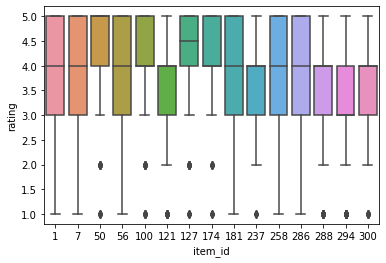

In [66]:
# box plot
import matplotlib.pyplot as plt 
import seaborn as sns 

ax = sns.boxplot(x='item_id', y='rating', data=train_pop_15_records)

/Users/nipunpathitage/opt/anaconda3/envs/rec/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


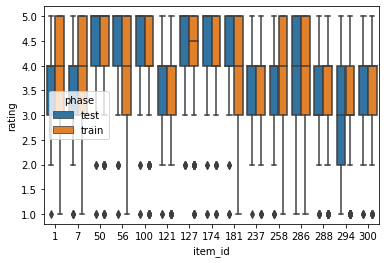

In [71]:
k = test_df.loc[test_df['item_id'].isin(train_pop_15), :]
k['phase'] = 'test'
e = train_pop_15_records.copy()
e['phase'] = 'train'
w = pd.concat([k, e], axis=0)
ax = sns.boxplot(x='item_id', y='rating', hue='phase', data=w)

/Users/nipunpathitage/opt/anaconda3/envs/rec/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/nipunpathitage/opt/anaconda3/envs/rec/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


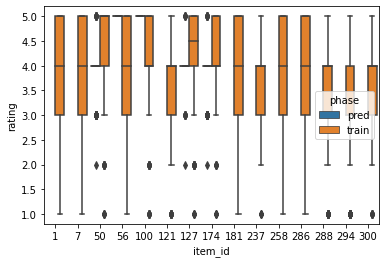

In [76]:
k = pred_df.loc[pred_df['item_id'].isin(train_pop_15), :]
k['rating'] = k['prediction'].astype(int)
k['phase'] = 'pred'
e = train_pop_15_records.copy()
e['phase'] = 'train'
w = pd.concat([k, e], axis=0)
ax = sns.boxplot(x='item_id', y='rating', hue='phase', data=w)